# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
from tqdm import tqdm

from PIL import Image
import os
import copy
from imagecorruptions import corrupt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
os.chdir("..") #navigate to where safeml is

In [4]:
from safeml.DistanceMetricsParallel import CVM_Dist_PVal as CVM_p
from safeml.DistanceMetricsParallel import Anderson_Darling_Dist_PVal as AD_p
from safeml.DistanceMetricsParallel import Kolmogorov_Smirnov_Dist_PVal as KS_p
from safeml.DistanceMetricsParallel import Wasserstein_Dist_PVal as WS_p
from safeml.DistanceMetricsParallel import DTS_Dist_PVal as DTS_p
from safeml.DistanceMetricsParallel import ES_Dist

In [5]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 32 #import as 32x32 minimum size required by corrpution
width = 32
channels = 3

n_inputs = height * width*channels

ClassFolders = os.listdir("Final_Training/Images")
classes = len(ClassFolders)

for idx, fileName in enumerate(ClassFolders) :
    path = os.path.join("Final_Training/Images", fileName)
    #path = "C:/cmder/Python_Tests/GTSRB/Train/{0}/".format(i)
    print(path)
    classImges = os.listdir(path)
    for img in classImges:
        try:
            image=cv2.imread(os.path.join(path, img))
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(idx)
        except AttributeError:
            print(os.path.join(path, img) + " is not an image")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

Final_Training/Images\00001
Final_Training/Images\00001\GT-00001.csv is not an image
Final_Training/Images\00002
Final_Training/Images\00002\GT-00002.csv is not an image
Final_Training/Images\00003
Final_Training/Images\00003\GT-00003.csv is not an image
Final_Training/Images\00004
Final_Training/Images\00004\GT-00004.csv is not an image
Final_Training/Images\00005
Final_Training/Images\00005\GT-00005.csv is not an image
Final_Training/Images\00006
Final_Training/Images\00006\GT-00006.csv is not an image
Final_Training/Images\00007
Final_Training/Images\00007\GT-00007.csv is not an image
Final_Training/Images\00008
Final_Training/Images\00008\GT-00008.csv is not an image
Final_Training/Images\00009
Final_Training/Images\00009\GT-00009.csv is not an image
Final_Training/Images\00010
Final_Training/Images\00010\GT-00010.csv is not an image
Final_Training/Images\00011
Final_Training/Images\00011\GT-00011.csv is not an image
Final_Training/Images\00012
Final_Training/Images\00012\GT-00012.

# Modelling

## Data prep
This X_test_init file is needed to apply corrution to the raw image before normalizing it in an array.

In [6]:
X_train_init, X_val_init, y_train_init, y_val_init = train_test_split(Cells, labels, test_size=0.40, random_state=42, stratify=labels)
X_val_init, X_test_init, y_val_init, y_test_init = train_test_split(X_val_init, y_val_init, test_size=0.7, random_state=42, stratify=y_val_init)


In [7]:
X_train = X_train_init.astype('float32')/255 
X_val = X_val_init.astype('float32')/255
X_test = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train_init.shape, y_val_init.shape, y_test_init.shape)

(22555, 32, 32, 3) (4511, 32, 32, 3) (10526, 32, 32, 3)
(22555,) (4511,) (10526,)


In [10]:
#select a random 50% fo the test data indecies to be corrupted
corruption_id = np.random.choice(X_test.shape[0], size = math.ceil(0.5 *X_test.shape[0]), replace=False)

# in percentages, 0-75 frost, 25-100 fog with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['frost', 'snow']
X_test_corrupted = copy.deepcopy(X_test) #copy to override

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_test_corrupted[i,:] = image.astype('float32')/255 #normalize
            

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.45s/it]


In [11]:
#split into calibration and evaluation
X_cal, X_eval, y_cal_init, y_eval_init = train_test_split(X_test_corrupted, y_test_init, test_size=0.5, random_state=42, stratify=y_test_init)


In [12]:
y_train = keras.utils.to_categorical(y_train_init, classes)
y_val = keras.utils.to_categorical(y_val_init, classes)
y_cal = keras.utils.to_categorical(y_cal_init, classes)
y_eval = keras.utils.to_categorical(y_eval_init, classes)

In [13]:
print(X_train.shape, X_val.shape, X_cal.shape)
print(y_train.shape, y_val.shape, y_cal.shape)

(22555, 32, 32, 3) (4511, 32, 32, 3) (5263, 32, 32, 3)
(22555, 42) (4511, 42) (5263, 42)


## Create Model

In [14]:
def build_model(input_shape, num_features, num_labels):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(num_features, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))

    return model

def compile_model(model, lr, loss='categorical_crossentropy', optimizer='adam', acc_metric = "accuracy"):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
    model.compile(loss=loss, optimizer=optimizer, metrics=[acc_metric])
    
    return model

In [15]:
lr = .001
max_epochs = 50
patience = 10
batch_size = 128
input_shape =X_train.shape[1:]
num_features = 100
num_labels = classes

In [16]:
model = build_model(input_shape, num_features, num_labels)
model = compile_model(model, lr)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)                    
history = model.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            shuffle=False, callbacks=[callback])

In [20]:
accr = model.evaluate(X_cal, y_cal)
print(accr)

165/165 [==============================] - 2s 9ms/step - loss: 1.3944 - accuracy: 0.6399
[1.3943884372711182, 0.6399391889572144]


In [ ]:
import pickle

save = (X_cal, X_eval, y_cal, y_eval)
with open('model.pkl', 'wb') as file:
      
    pickle.dump(model, file)
    
with open('EvalCal_iter3.pkl', 'wb') as file:
      
    pickle.dump(save, file)

In [ ]:
import pickle

with open('model.pkl', 'rb') as file:
      
    model = pickle.load(file)

# SafeML Estimators

## Separation and Transforamtion

In [19]:
y_pred = np.argmax(model.predict(X_cal), 1)
y_real = np.argmax(y_cal, 1)

165/165 [==============================] - 1s 8ms/step


In [21]:
#Create mask for incorrect data
mask = np.zeros(len(y_pred))
for idx, yp in enumerate(y_pred):
    mask[idx] = yp == y_real[idx]
    
print(mask)

[1. 1. 1. ... 0. 1. 1.]


In [22]:
print(len(mask) - mask.sum() ) # Number of incorrect examples

1895.0


In [23]:
#Filter to extract the features from last layer

def create_filter(model):
    
    x = model.layers[-2].output
    output = Model(inputs = model.input, outputs= x)
    
    return output

filter_model = create_filter(model)

In [24]:
filtered_train = filter_model.predict(X_train)
filtered_cal = filter_model.predict(X_cal)
filtered_eval = filter_model.predict(X_eval)

165/165 [==============================] - 1s 8ms/step


In [25]:
#Create PCA components to reduce computation
pca = PCA(n_components=15)
train_components = pca.fit_transform(filtered_train)
print(pca.explained_variance_)

[313.69495  191.80367  154.9346   138.44244  106.84725   99.90364
  86.584435  81.33258   73.04964   48.20886   41.880775  33.029015
  29.081749  24.657778  20.980577]


In [26]:
explained = pca.explained_variance_ratio_
explained = [sum(explained[:x]) for x in range(1,len(explained))]
print(explained)

[0.19487138092517853, 0.31402231752872467, 0.41026970744132996, 0.4962719529867172, 0.562646858394146, 0.6247082985937595, 0.6784956753253937, 0.729020532220602, 0.7743999175727367, 0.804347887635231, 0.8303647711873055, 0.8508828245103359, 0.8689487855881453, 0.8842665180563927]


Text(0.5, 0, 'component number')

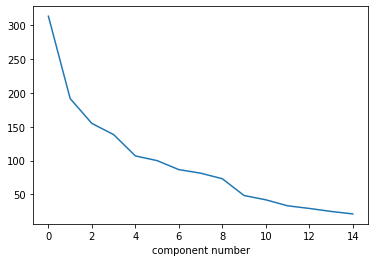

In [27]:
fig, ax1 = plt.subplots()
plt.plot(pca.explained_variance_)


plt.xlabel('component number')

At 6 correspondint to 66% explained variance and at 12 for 85% explained variance ration
12 was chosen


In [28]:
cal_components = pca.transform(filtered_cal)

## Create Set of Batches

In [29]:
cal_correct = cal_components[mask == 1, :12]
cal_incorrect = cal_components[mask ==0, :12]

print(cal_correct.shape, cal_incorrect.shape)

(3368, 12) (1895, 12)


In [30]:
def design_windowed_series(data_input, required_samples, instance_num):
    correct, incorrect = data_input
    
    _out = np.zeros((instance_num, required_samples, correct.shape[1]))
    _acc = np.zeros(instance_num)
    rng = np.random.default_rng()
    for idx, x in enumerate(np.linspace(0, required_samples, instance_num)):
        samples = math.ceil(x)
        _acc[idx] = 1 - (samples / required_samples) #decrease accuracy over time
        incorrect_id = np.random.choice(incorrect.shape[0], samples)
        correct_id = np.random.choice(correct.shape[0], required_samples - samples)
        
        _out[idx] = (np.concatenate((incorrect[incorrect_id, :], correct[correct_id, :]), axis = 0))
        rng.shuffle(_out[idx], axis = 0)
        
    return _out, _acc

In [31]:
required_samples = 50
designed_series, accuracy = design_windowed_series((cal_correct, cal_incorrect), required_samples, 1500)


In [32]:
#The designed set contians 1500 batches, each with 50 samples, each of 12 pca components of the image.
#the accuracy of those 40 samples is decreasing.
designed_series.shape

(1500, 50, 12)

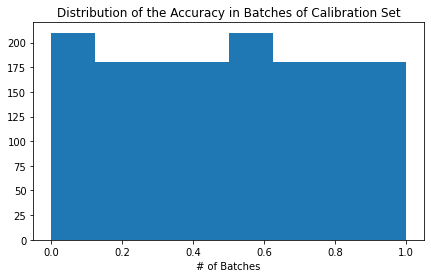

In [33]:
plt.figure(figsize=[7,4])
plt.hist(accuracy, bins=8)
plt.title("Distribution of the Accuracy in Batches of Calibration Set")
plt.xlabel("Accuracy")
plt.xlabel("# of Batches")
plt.show()

## SafeML Implementation

In [34]:
def get_statistical_distance_gpu(train_set, test_set):
    #return statistical distance measures
    if (train_set.shape[1] != test_set.shape[1]):
        print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
        return None
    else:
        input_features = train_set.shape[1]
        
    input_features = train_set.shape[1]
    

    ss_CVM_distances = np.zeros(input_features)
    ss_Anderson_Darling_distances = np.zeros(input_features)
    ss_Kolmogorov_Smirnov_distances = np.zeros(input_features)
    ss_Wasserstein_distances = np.zeros(input_features)
    ss_DTS_distances = np.zeros(input_features)
    es_distances = np.zeros(input_features)
    for i in range(input_features):
        
        pVal_cvm, cvm_res = CVM_p(train_set[:, i], test_set[:, i])
        ss_CVM_distances[i] = cvm_res if (pVal_cvm < 0.05) else np.nan

        
        pVal_ad, ad_res = AD_p(train_set[:, i], test_set[:, i])
        ss_Anderson_Darling_distances[i] = ad_res if (pVal_ad < 0.05) else np.nan
        
        
        pVal_ks, ks_res = KS_p(train_set[:, i], test_set[:, i])
        ss_Kolmogorov_Smirnov_distances[i] = ks_res if (pVal_ks < 0.05) else np.nan
        
        
        pVal_ws, ws_res = WS_p(train_set[:, i], test_set[:, i])
        ss_Wasserstein_distances[i] = ws_res if (pVal_ws < 0.05) else np.nan

        
        pVal_dts, dts_res = DTS_p(train_set[:, i], test_set[:, i])
        ss_DTS_distances[i] = dts_res if (pVal_dts < 0.05) else np.nan
        
        es_distances[i], _ = ES_Dist(train_set[:, i], test_set[:, i])
    
    CVM_distance = (np.nanmean(ss_CVM_distances, dtype=np.float64), 
                    np.nanstd(ss_CVM_distances, dtype=np.float64))
    Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
                                 np.nanstd(ss_Anderson_Darling_distances, dtype=np.float64))
    Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),
                                   np.nanstd(ss_Kolmogorov_Smirnov_distances, dtype=np.float64))
    Wasserstein_distance = (np.nanmean(ss_Wasserstein_distances, dtype=np.float64),
                            np.nanstd(ss_Wasserstein_distances, dtype=np.float64))
    
    dts_distance = (np.nanmean(ss_DTS_distances, dtype=np.float64),
                            np.nanstd(ss_DTS_distances, dtype=np.float64))
    
    es_distance = (np.mean(es_distances, dtype=np.float64),
                            np.std(es_distances, dtype=np.float64))
    

    
    return {
            'CVM_dist': CVM_distance,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Wasserstein_dist': Wasserstein_distance,
            'DTS_dist' : dts_distance,
            "ES_dist"  : es_distance
           }

In [35]:
def distance_list(input_series, train_ref, acc_list):
    N = len(acc_list)
    
    cvm = np.zeros(N)
    ad = np.zeros(N)
    ks = np.zeros(N)
    ws = np.zeros(N)
    dts = np.zeros(N)
    es = np.zeros(N)
    
    for i in tqdm(range(N)):
        dist = get_statistical_distance_gpu(train_ref, input_series[i, :, :])
        
        cvm[i] = dist['CVM_dist'][0]
        ad[i] = dist['Anderson_Darling_dist'][0]
        ks[i] = dist['Kolmogorov_Smirnov_dist'][0]
        ws[i] = dist['Wasserstein_dist'][0]
        dts[i] = dist['DTS_dist'][0]
        es[i] = dist['ES_dist'][0]
        
    return (cvm, ad, ks, ws, dts, es)

In [36]:
#prepare a training sample
idx_train = np.random.choice(filtered_train.shape[0], required_samples * 2, replace=False)
train_samples = train_components[idx_train, :12]

train_samples.shape

(100, 12)

The following code snippet takes a while due to number of distances calculated

In [37]:

cvm, ad, ks, ws, dts, es = distance_list(designed_series, train_samples, accuracy)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:19:49<00:00,  3.19s/it]


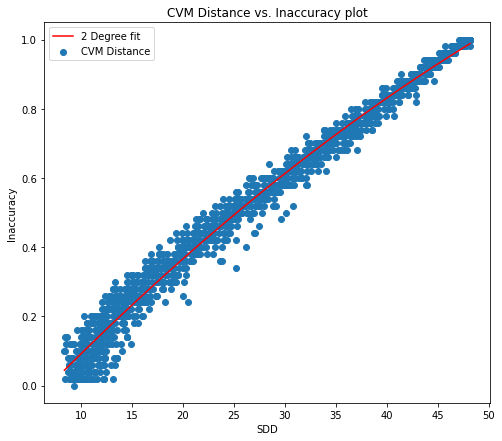

In [38]:
z = np.polyfit(cvm, 1 - accuracy, 2)
x_fit = np.linspace(cvm.min(), cvm.max(), cvm.shape[0])
fit = np.poly1d(z)(x_fit)

plt.figure(figsize=(8,7))

plt.scatter(cvm, 1 - accuracy,  label='CVM Distance')
plt.plot(x_fit, fit, "r")
plt.title('CVM Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "CVM Distance"])


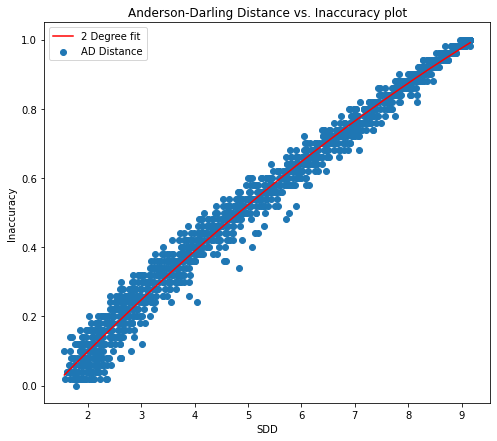

In [39]:
z = np.polyfit(ad, 1 - accuracy, 2)
x_fit = np.linspace(ad.min(), ad.max(), ad.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(ad, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Anderson-Darling Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "AD Distance"])


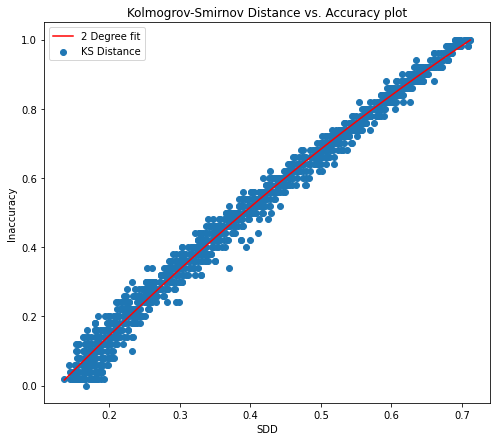

In [40]:
z = np.polyfit(ks, 1 - accuracy, 2)
x_fit = np.linspace(ks.min(), ks.max(), ks.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(ks, 1 - accuracy)
plt.plot(x_fit, fit, "r")
plt.title('Kolmogrov-Smirnov Distance vs. Accuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "KS Distance"])

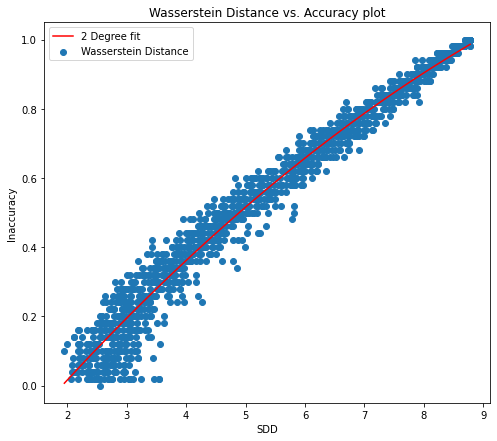

In [41]:
z = np.polyfit(ws, 1 - accuracy, 2)
x_fit = np.linspace(ws.min(), ws.max(), ws.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(ws, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Wasserstein Distance vs. Accuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "Wasserstein Distance"])

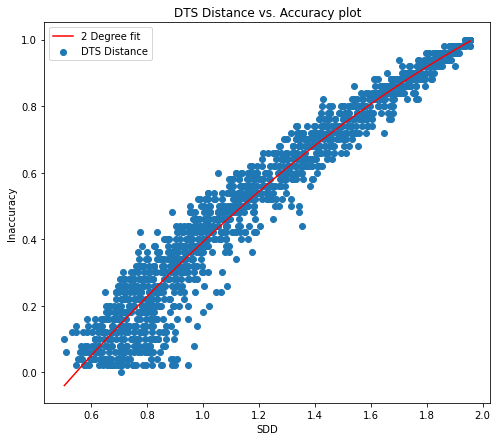

In [42]:
z = np.polyfit(dts, 1 - accuracy, 2)
x_fit = np.linspace(dts.min(), dts.max(), dts.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(dts, 1 - accuracy)
plt.plot(x_fit, fit, "r")
plt.title('DTS Distance vs. Accuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "DTS Distance"])

Parameters: [ 0.23129761 -0.842959   -0.25470828]
RMSE: 0.3763816053283876
R-squared: 0.7742705671637531


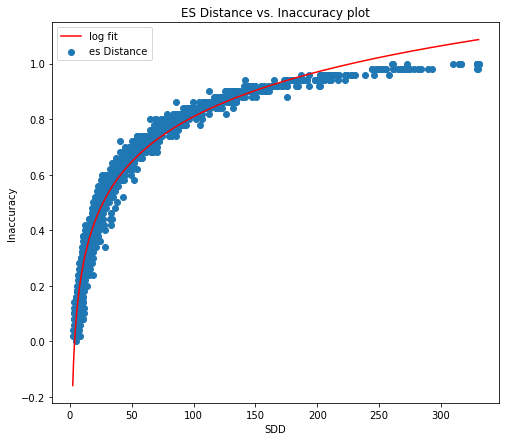

In [43]:
from scipy.optimize import curve_fit

def ln_fun(x, a, b, c): 
    return a*np.log(x + b)+c


x_fit = np.linspace(es.min(), es.max(), es.shape[0])



# these are the same as the scipy defaults
param_init = np.array([1.0, 1.0, 1.0])

# curve fit the test data
param_fit, pcov = curve_fit(ln_fun, es, (1 - accuracy), param_init)

fit_log = ln_fun(x_fit, *param_fit) 

absError = fit_log - (1 - accuracy)

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(1 - accuracy))

print('Parameters:', param_fit)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


plt.figure(figsize=(8,7))
plt.scatter(es, 1 - accuracy,  label='ES Distance')
plt.plot(x_fit, fit_log, "r")
plt.title('ES Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["log fit", "es Distance"])


In [234]:
import pickle

save = (cvm, ad, ks, ws, dts, es, accuracy)
with open('iter1_dist.pkl', 'wb') as file:
      
    pickle.dump(save, file)

# Evaluation

## Data batching
a moving window will go over the evalaution set to create a similar series of batches

In [44]:
def create_windowed_series(data_input, required_samples_threshold, window_overlap): 

    n_features = data_input.shape[1:]
    stride = math.ceil(required_samples * (1 - window_overlap))
    n_series = (math.floor((len(data_input) - required_samples)/stride) + 1)
    
    windowed_data = np.zeros((n_series,
                              required_samples) +
                              n_features)
                             

    for idx in range(n_series):
        windowed_data[idx] = data_input[(idx*stride): (idx*stride) +  required_samples_threshold]


    return windowed_data


In [45]:
window_overlap = 0.8

windowed_series = create_windowed_series(X_eval , required_samples, window_overlap)
windowed_eval = create_windowed_series(np.argmax(y_eval, 1).reshape(-1, 1), required_samples, window_overlap) #reshape groundtruth

## Weight and Measure distance

In [46]:
# transformer from 50x32x32x3 to 50x12
def data_transform(data, model_filter = filter_model, pca = pca, comp = 12):
    
    filtered = model_filter.predict(data)
    components = pca.transform(filtered)
    
    return components[:,:comp]

In [47]:
def get_dist(data_input, train_ref):
    dist = get_statistical_distance_gpu(train_ref, data_input)
        
    cvm = dist['CVM_dist'][0]
    ad = dist['Anderson_Darling_dist'][0]
    ks = dist['Kolmogorov_Smirnov_dist'][0]
    ws = dist['Wasserstein_dist'][0]
    dts = dist['DTS_dist'][0]
    es = dist['ES_dist'][0]
    
    return np.array([cvm, ad, ks, ws, dts, es])

In [48]:
#Use vanilla cost function of +10, -20
def vanilla_eval(data_input, eval_data, model, train_ref = train_samples):
    weights = np.zeros(data_input.shape[0])
    distances = np.zeros((data_input.shape[0], 6))
    acc = np.zeros(data_input.shape[0])
    
    for idx, batch in enumerate(data_input):
        
        trans_data = data_transform(batch) 
        pred_out = np.argmax(model.predict(batch), 1).reshape(-1, 1) # This step can be done before batching to make process faster
        weights[idx] = np.sum((pred_out == eval_data[idx])*3 -2)*10
        distances[idx, :] = get_dist(trans_data, train_ref)
        acc[idx] = np.sum((pred_out == eval_data[idx]))/len(batch)
        
    return (weights, distances, acc)
         

In [ ]:
weights, distances, eval_acc = vanilla_eval(windowed_series, windowed_eval, model)

In [70]:
import pickle

save = (weights, distances, eval_acc)
with open('iter1_evalCC.pkl', 'wb') as file:
      
    pickle.dump(save, file)

## Build Estimator

In [50]:
def create_estimator_poly(dist_list, acc, degree= 2):
    z = np.polyfit(dist_list, 1 - acc, degree)
    
    def est(dist): #The function should be bound up and down
        if dist > dist_list[-1]:
            return 1
        
        elif dist < dist_list[0]:
            return 0
        
        else:
            return np.poly1d(z)(dist)
        
    return est

def create_estimator_log(es, accuracy):
    
    
    x_fit = np.linspace(es.min(), es.max(), es.shape[0])

    # these are the same as the scipy defaults
    param_init = np.array([1.0, 1.0, 1.0])
    param_fit, _ = curve_fit(ln_fun, es, (1 - accuracy), param_init)


    
    x_fit = np.linspace(es.min(), es.max(), es.shape[0])
    
    below_zero = None
    above_one = None
    for idx, x in enumerate(x_fit):
        if below_zero is None:
            if ln_fun(x, *param_fit) >= 0: below_zero = idx
                
        if above_one is None:
            if ln_fun(x, *param_fit) >= 1: 
                above_one = idx - 1
                break
    
    def est(dist): #The function should be bound up and down

        if dist > x_fit[above_one]:
            return 1
        
        elif dist < x_fit[below_zero]:
            return 0
        
        else:
            return ln_fun(dist, *param_fit)
        
    return est

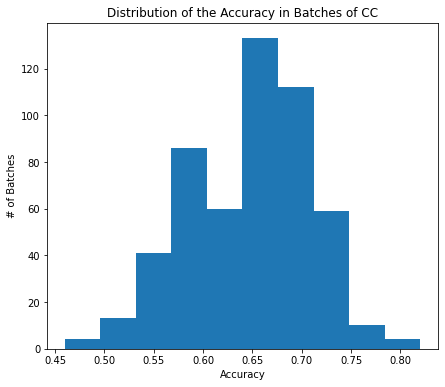

Min accuracy in the barches: 0.46
Max accuracy in the batches: 0.82


In [51]:
plt.figure(figsize=[7,6])
plt.hist(eval_acc)
plt.title("Distribution of the Accuracy in Batches of CC")
plt.xlabel("Accuracy")
plt.ylabel("# of Batches")
plt.show()

print(f"Min accuracy in the barches: {eval_acc.min()}\nMax accuracy in the batches: {eval_acc.max()}")

In [52]:
print(weights.mean(), weights.sum())

-32.35632183908046 -16890.0


### CVM distance

In [53]:
cvm_estimator = create_estimator_poly(cvm, accuracy)

In [54]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances):
    if cvm_estimator(dist[0]) < uncer_thresh:
        total_weight += weights[idx]
        
mean_weight = total_weight / len(weights)

In [55]:
print(mean_weight, total_weight)

-30.21072796934866 -15770.0


Obvios decrease in weight

In [56]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if cvm_estimator(dist[0]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [57]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 4
within the accuracy range: 0.46 0.5


(10.0, 30.0)

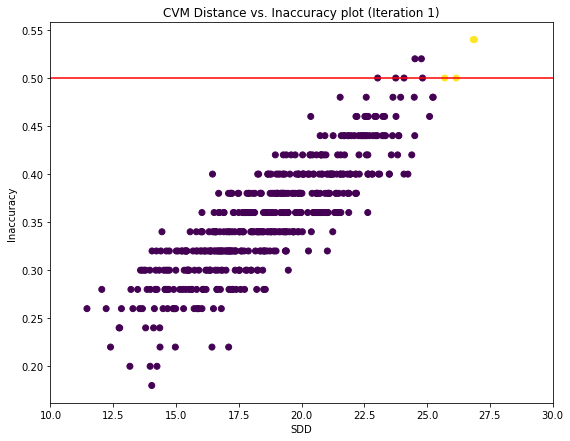

In [59]:
plt.figure(figsize=(9,7))
plt.scatter(distances[:, 0], 1- eval_acc,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 6, xmax = 30, colors = 'r')
plt.xlim(10, 30)





In [60]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if cvm_estimator(dist[0]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 516 0 2


## Anderson Darling

In [61]:
ad_estimator = create_estimator_poly(ad, accuracy)

In [62]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if ad_estimator(dist[1]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [63]:
print(mean_weight, total_weight)

-29.846743295019156 -15580.0


In [64]:
rejected = []
c_mask = np.zeros(len(distances))

for idx, dist in enumerate(distances):
    if ad_estimator(dist[1]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [65]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

5
0.46 0.54


(2.0, 6.0)

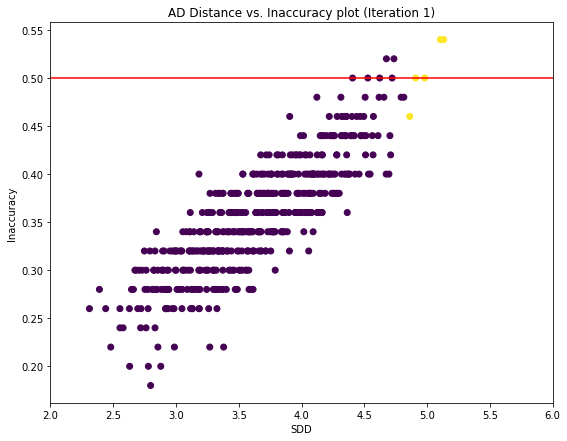

In [66]:
plt.figure(figsize=(9,7))
plt.scatter(distances[:, 1],1-eval_acc,  c=c_mask)
plt.title('AD Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(2, 6)



In [67]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if ad_estimator(dist[1]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 515 1 2


## Kolmogrov Smirnov

In [68]:
ks_estimator = create_estimator_poly(ks, accuracy)

In [69]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if ks_estimator(dist[2]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [70]:
print(mean_weight, total_weight)

-28.773946360153257 -15020.0


In [71]:
rejected = []
c_mask = np.zeros(len(distances))

for idx, dist in enumerate(distances):
    if ks_estimator(dist[2]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [72]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

7
0.46 0.52


(0.18, 0.45)

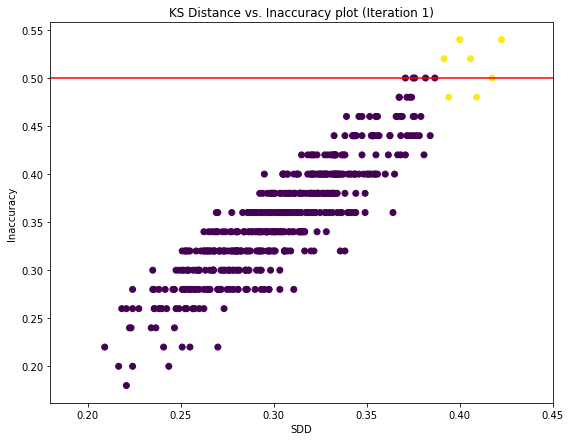

In [73]:
plt.figure(figsize=(9,7))
plt.scatter(distances[:, 2],1-eval_acc,  c=c_mask)
plt.title('KS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(0.18, 0.45)



In [74]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if ks_estimator(dist[2]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

5 515 2 0


## Wasserstein

In [75]:
ws_estimator = create_estimator_poly(ws, accuracy)

In [76]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if ws_estimator(dist[3]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [77]:
print(mean_weight, total_weight)

-28.697318007662837 -14980.0


In [78]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if ws_estimator(dist[3]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [79]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

8
0.46 0.56


(2.4, 5.5)

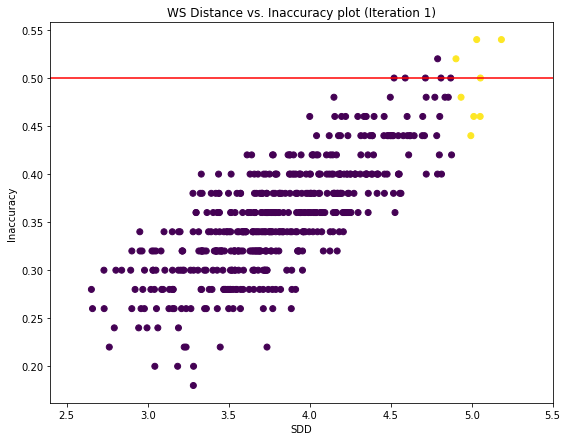

In [80]:
plt.figure(figsize=(9, 7))
plt.scatter(distances[:, 3],1-eval_acc,  c=c_mask)
plt.title('WS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(2.4, 5.5)


In [81]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if ws_estimator(dist[3]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 513 4 1


## DTS

In [82]:
dts_estimator = create_estimator_poly(dts, accuracy)

In [83]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if dts_estimator(dist[4]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [84]:
print(mean_weight, total_weight)

-24.17624521072797 -12620.0


In [85]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if dts_estimator(dist[4]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [86]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

25
0.46 0.66


(0.6, 1.3)

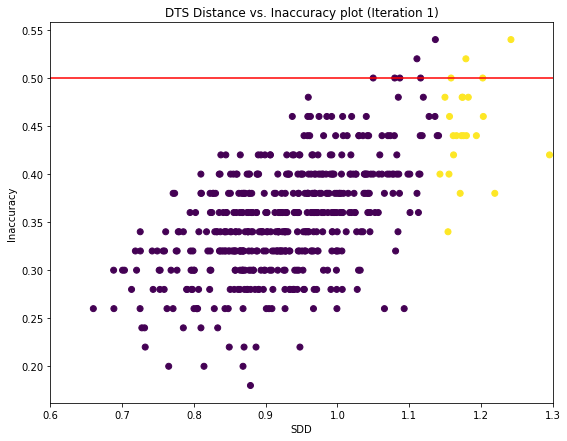

In [87]:
plt.figure(figsize=(9, 7))
plt.scatter(distances[:, 4],1-eval_acc,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(.6, 1.3)


In [88]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if dts_estimator(dist[4]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 495 21 2


### ES-Test

In [89]:
es_estimator = create_estimator_log(es, accuracy)

In [90]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances):

    if es_estimator(dist[5]) < uncer_thresh:
        total_weight += weights[idx]
        
mean_weight = total_weight / len(weights)

In [91]:
print(mean_weight, total_weight)

-31.149425287356323 -16260.0


In [93]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if es_estimator(dist[5]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [94]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

3
0.46 0.56


(5.0, 30.0)

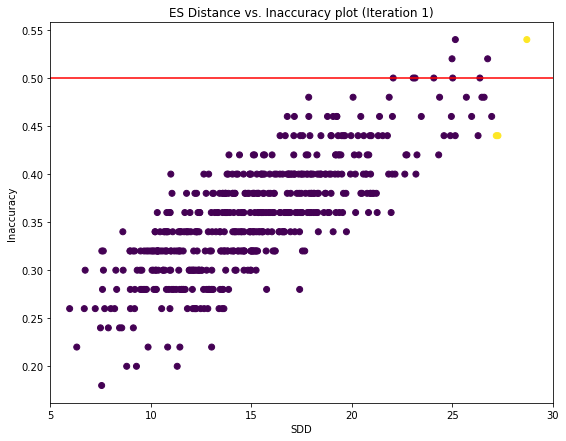

In [96]:
plt.figure(figsize=(9, 7))
plt.scatter(distances[:, 5],1-eval_acc,  c=c_mask)
plt.title('ES Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(5, 30)



In [99]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if es_estimator(dist[5]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

1 516 2 3


## Semi-Out of Context Evaluation

In [100]:
X_oc = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

#select a random 50% fo the test data indecies to be corrupted
corruption_id = np.random.choice(X_oc.shape[0], size = math.ceil(0.5 *X_oc.shape[0]), replace=False)

# in percentages, 0-75 frost, 25-100 fog with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['frost', 'fog']

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_oc[i,:] = image.astype('float32')/255 #normalize
            

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.35s/it]


In [101]:
#split into calibration and evaluation
_, X_evalOC, _, y_evalOC_init = train_test_split(X_oc, y_test_init, test_size=0.5, random_state=42, stratify=y_test_init)
y_evalOC = keras.utils.to_categorical(y_evalOC_init, classes)

In [102]:
accr = model.evaluate(X_evalOC, y_evalOC)
print(accr)

165/165 [==============================] - 1s 9ms/step - loss: 1.4108 - accuracy: 0.6409
[1.410799264907837, 0.6408892273902893]


In [103]:
def create_windowed_series(data_input, required_samples_threshold, window_overlap): 

    n_features = data_input.shape[1:]
    stride = math.ceil(required_samples * (1 - window_overlap))
    n_series = (math.floor((len(data_input) - required_samples)/stride) + 1)
    
    windowed_data = np.zeros((n_series,
                              required_samples) +
                              n_features)
                             

    for idx in range(n_series):
        windowed_data[idx] = data_input[(idx*stride): (idx*stride) +  required_samples_threshold]


    return windowed_data


In [104]:
window_overlap = 0.8

windowed_series_oc = create_windowed_series(X_evalOC , required_samples, window_overlap)
windowed_eval_oc = create_windowed_series(np.argmax(y_evalOC, 1).reshape(-1, 1), required_samples, window_overlap) #reshape groundtruth

In [105]:
windowed_series_oc.shape

(522, 50, 32, 32, 3)

In [ ]:
weights_oc, distances_oc, eval_acc_oc = vanilla_eval(windowed_series_oc, windowed_eval_oc, model)

In [303]:

save = (weights_oc, distances_oc, dist_es_oc, eval_acc_oc)
with open('iter1_soc.pkl', 'wb') as file:
      
    pickle.dump(save, file)

In [107]:
print(weights_oc.mean(), weights_oc.sum())

-39.13793103448276 -20430.0


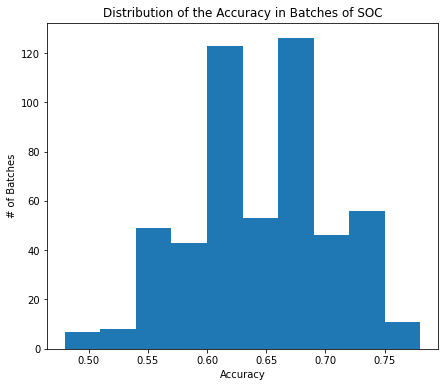

Min accuracy in the barches: 0.48
Max accuracy in the batches: 0.78


In [108]:
plt.figure(figsize=[7,6])
plt.hist(eval_acc_oc)
plt.title("Distribution of the Accuracy in Batches of SOC")
plt.xlabel("Accuracy")
plt.ylabel("# of Batches")
plt.show()

print(f"Min accuracy in the barches: {eval_acc_oc.min()}\nMax accuracy in the batches: {eval_acc_oc.max()}")

### CVM distance

In [121]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc):
    if cvm_estimator(dist[0]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
mean_weight = total_weight / len(weights_oc)

In [122]:
print(mean_weight, total_weight)

-34.367816091954026 -17940.0


In [123]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if cvm_estimator(dist[0]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [124]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 12
within the accuracy range: 0.48 0.58


(11.0, 28.0)

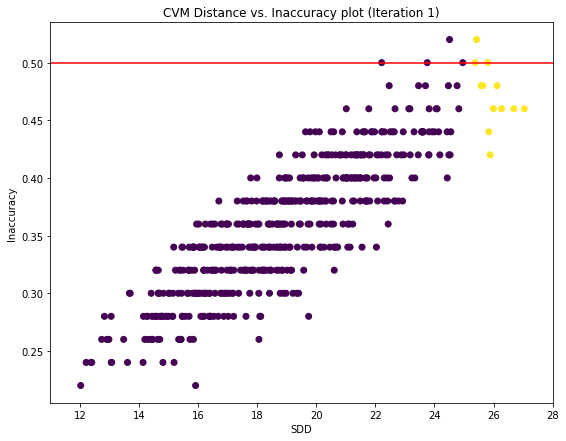

In [125]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc[:, 0],1-eval_acc_oc,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(11, 28)

In [126]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if cvm_estimator(dist[0]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

3 509 9 1


### Anderson Darling distance

In [127]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if ad_estimator(dist[1]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [128]:
print(mean_weight, total_weight)

-34.90421455938697 -18220.0


In [129]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if ad_estimator(dist[1]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [130]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 11
within the accuracy range: 0.5 0.58


(2.0, 5.6)

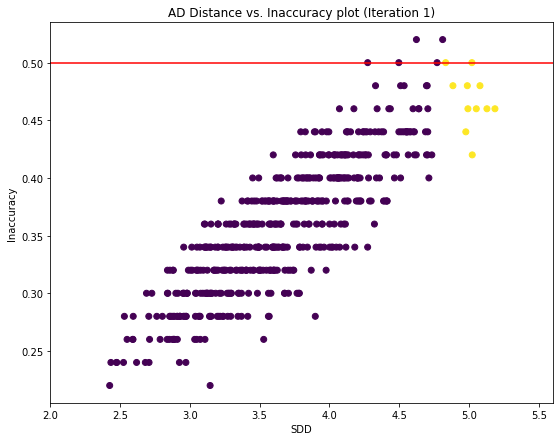

In [131]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc[:, 1],1-eval_acc_oc,  c=c_mask)
plt.title('AD Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(2, 5.6)

In [132]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if ad_estimator(dist[1]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

2 509 9 2


### Kolmogrov Smirnov

In [133]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if ks_estimator(dist[2]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [134]:
print(mean_weight, total_weight)

-35.53639846743295 -18550.0


In [135]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if ks_estimator(dist[2]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [136]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 8
within the accuracy range: 0.48 0.54


(0.2, 0.45)

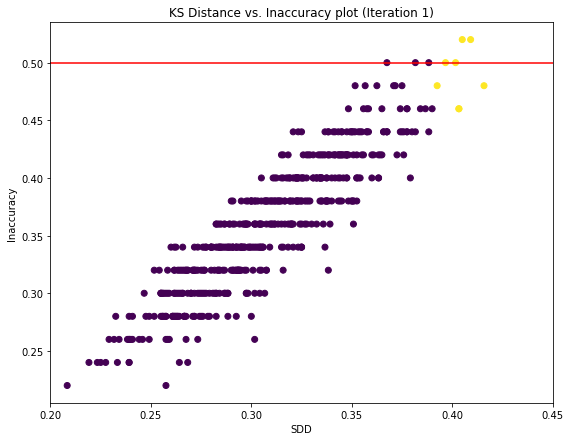

In [138]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc[:, 2],1-eval_acc_oc,  c=c_mask)
plt.title('KS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(0.2, 0.45)

In [139]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if ks_estimator(dist[2]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 514 4 0


### Wasserstein 

In [140]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if ws_estimator(dist[3]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [141]:
print(mean_weight, total_weight)

-35.30651340996169 -18430.0


In [142]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if ws_estimator(dist[3]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [143]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 11
within the accuracy range: 0.5 0.58


(2.5, 5.5)

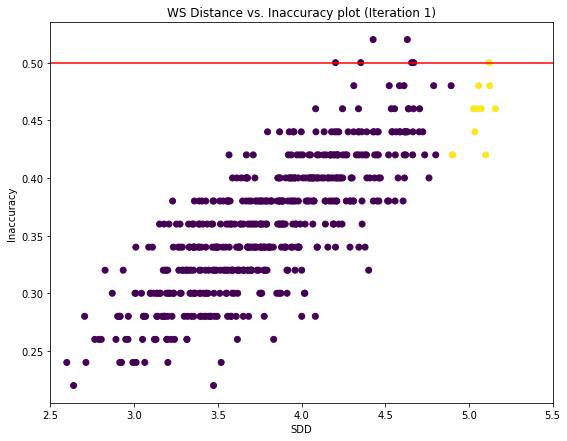

In [145]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc[:, 3],1-eval_acc_oc,  c=c_mask)
plt.title('WS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(2.5, 5.5)

In [146]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if ws_estimator(dist[3]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

1 509 10 2


### DTS

In [147]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if dts_estimator(dist[4]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [148]:
print(mean_weight, total_weight)

-33.14176245210728 -17300.0


In [149]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if dts_estimator(dist[4]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [150]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 19
within the accuracy range: 0.5 0.6


(0.6, 1.3)

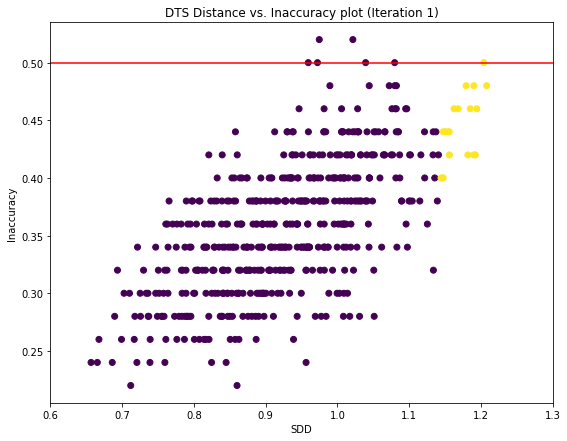

In [151]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc[:, 4],1-eval_acc_oc,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(0.6, 1.3)

In [152]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if dts_estimator(dist[4]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

1 501 18 2


### ES Test

In [155]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc):

    if es_estimator(dist[5]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
mean_weight = total_weight / len(weights)

In [156]:
print(mean_weight, total_weight)

-35.99616858237548 -18790.0


In [158]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if es_estimator(dist[5]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [159]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 8
within the accuracy range: 0.5 0.58


(5.0, 30.0)

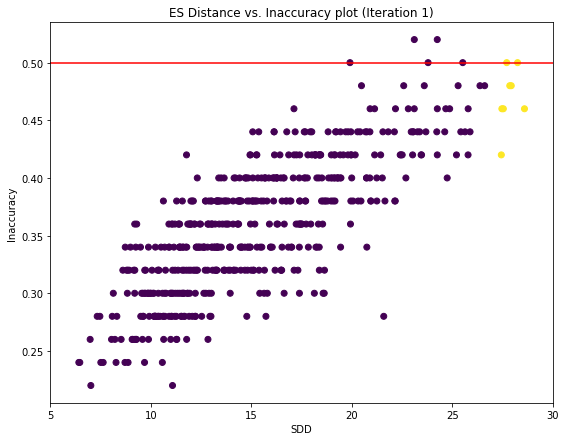

In [161]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc[:,5],1-eval_acc_oc,  c=c_mask)
plt.title('ES Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(5, 30)



In [162]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if es_estimator(dist[5]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

2 512 6 2


### Complete Out of Context Corruption

In [165]:
X_oc2 = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

#select a random 50% of the test data indecies to be corrupted
corruption_id = np.random.choice(X_oc2.shape[0], size = math.ceil(0.5 *X_oc2.shape[0]), replace=False)

# in percentages, 0-75 defocus_blur, 25-100 motion_blur with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['defocus_blur', 'motion_blur']

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_oc2[i,:] = image.astype('float32')/255 #normalize

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.49s/it]


In [166]:
#split into calibration and evaluation
_, X_evalOC2, _, y_evalOC_init = train_test_split(X_oc2, y_test_init, test_size=0.5, random_state=42, stratify=y_test_init)
y_evalOC = keras.utils.to_categorical(y_evalOC_init, classes)

In [167]:
accr = model.evaluate(X_evalOC2, y_evalOC)
print(accr)


165/165 [==============================] - 2s 10ms/step - loss: 1.4018 - accuracy: 0.6437
[1.401780366897583, 0.6437392830848694]


In [168]:
def create_windowed_series(data_input, required_samples_threshold, window_overlap): 

    n_features = data_input.shape[1:]
    stride = math.ceil(required_samples * (1 - window_overlap))
    n_series = (math.floor((len(data_input) - required_samples)/stride) + 1)
    
    windowed_data = np.zeros((n_series,
                              required_samples) +
                              n_features)
                             

    for idx in range(n_series):
        windowed_data[idx] = data_input[(idx*stride): (idx*stride) +  required_samples_threshold]


    return windowed_data


In [169]:

window_overlap = 0.8

windowed_series_oc2 = create_windowed_series(X_evalOC2 , required_samples, window_overlap)
windowed_eval_oc2 = create_windowed_series(np.argmax(y_evalOC, 1).reshape(-1, 1), required_samples, window_overlap) #reshape groundtruth

In [ ]:
weights_oc2, distances_oc2, eval_acc_oc2 = vanilla_eval(windowed_series_oc2, windowed_eval_oc2, model)

In [354]:
save = (weights_oc2, distances_oc2, dist_es_oc2, eval_acc_oc2)
with open('iter1_coc.pkl', 'wb') as file:
      
    pickle.dump(save, file)

In [172]:
print(weights_oc2.mean(), weights_oc2.sum())

-33.275862068965516 -17370.0


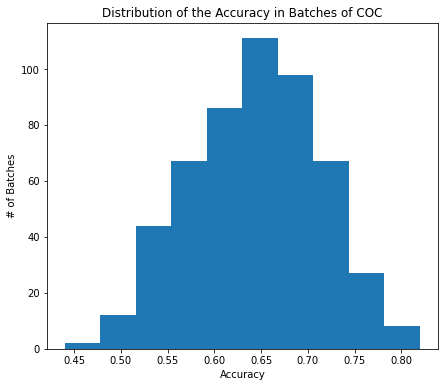

Min accuracy in the barches: 0.44
Max accuracy in the batches: 0.82


In [173]:
plt.figure(figsize=[7,6])
plt.hist(eval_acc_oc2)
plt.title("Distribution of the Accuracy in Batches of COC")
plt.xlabel("Accuracy")
plt.ylabel("# of Batches")
plt.show()

print(f"Min accuracy in the barches: {eval_acc_oc2.min()}\nMax accuracy in the batches: {eval_acc_oc2.max()}")

### CVM

In [174]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc2):
    if cvm_estimator(dist[0]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
mean_weight = total_weight / len(weights_oc2)

In [175]:
print(mean_weight, total_weight)

-27.39463601532567 -14300.0


In [176]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if cvm_estimator(dist[0]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [177]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 13
within the accuracy range: 0.44 0.56


(10.0, 28.0)

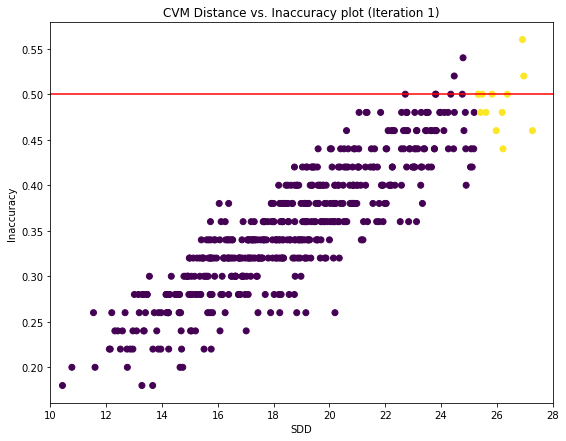

In [178]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc2[:, 0],1-eval_acc_oc2,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(10, 28)

In [179]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if cvm_estimator(dist[0]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

7 507 6 2


### Anderson Darling

In [180]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if ad_estimator(dist[1]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [181]:
print(mean_weight, total_weight)

-26.39846743295019 -13780.0


In [182]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if ad_estimator(dist[1]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [183]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 17
within the accuracy range: 0.44 0.6


(2.0, 5.5)

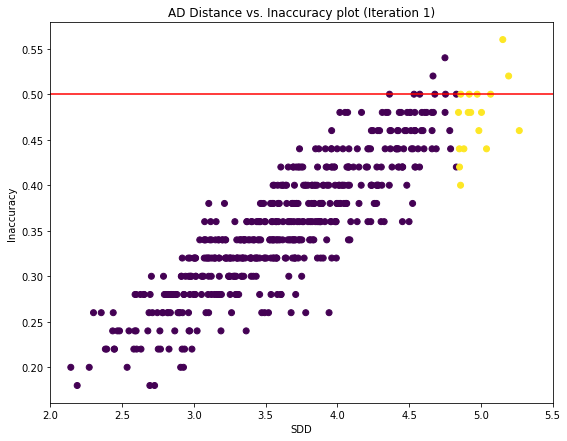

In [184]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc2[:, 1],1-eval_acc_oc2,  c=c_mask)
plt.title('AD Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(2, 5.5)

In [185]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if ad_estimator(dist[1]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

6 503 11 2


### Kolmogrov Smirnov

In [186]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if ks_estimator(dist[2]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [187]:
print(mean_weight, total_weight)

-28.18007662835249 -14710.0


In [188]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if ks_estimator(dist[2]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [189]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 11
within the accuracy range: 0.44 0.56


(0.15, 0.45)

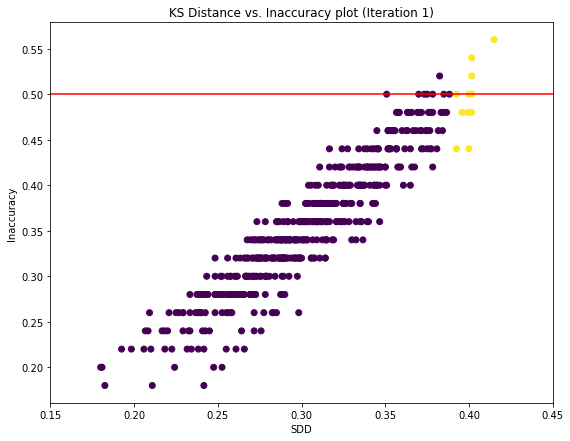

In [190]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc2[:, 2],1-eval_acc_oc2,  c=c_mask)
plt.title('KS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(.15, .45)

In [191]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if ks_estimator(dist[2]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

6 510 5 1


### Wasserstein

In [192]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if ws_estimator(dist[3]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [193]:
print(mean_weight, total_weight)

-27.375478927203066 -14290.0


In [194]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if ws_estimator(dist[3]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [195]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 14
within the accuracy range: 0.44 0.6


(2.5, 5.5)

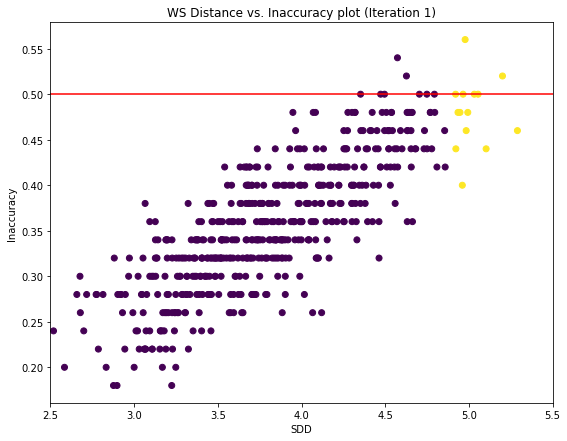

In [196]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc2[:, 3],1-eval_acc_oc2,  c=c_mask)
plt.title('WS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(2.5, 5.5)

In [197]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if ws_estimator(dist[3]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

6 506 8 2


### DTS Distance

In [198]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if dts_estimator(dist[4]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [199]:
print(mean_weight, total_weight)

-29.693486590038315 -15500.0


In [200]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if dts_estimator(dist[4]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [201]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 13
within the accuracy range: 0.48 0.68


(0.65, 1.3)

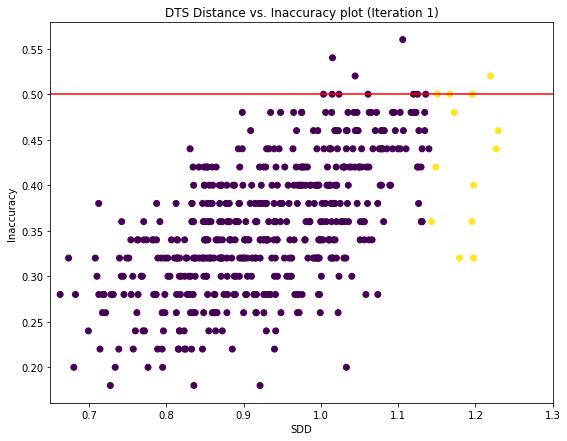

In [202]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc2[:, 4],1-eval_acc_oc2,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(0.65, 1.3)

In [203]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if dts_estimator(dist[4]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 506 9 3


### ES Test

In [205]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc2):

    if es_estimator(dist[5]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
mean_weight = total_weight / len(weights)

In [206]:
print(mean_weight, total_weight)

-29.655172413793103 -15480.0


In [207]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if es_estimator(dist[5]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [208]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 9
within the accuracy range: 0.44 0.6


(5.0, 31.0)

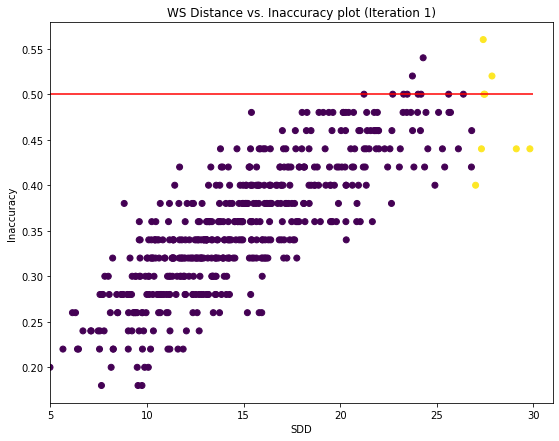

In [210]:
plt.figure(figsize=(9, 7))
plt.scatter(distances_oc2[:, 5], 1-eval_acc_oc2,  c=c_mask)
plt.title('WS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors = 'r')
plt.xlim(5, 31)

In [212]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if es_estimator(dist[5]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

4 511 5 2
